Name: Antony Krymski

Username: agk-123

In [276]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import os

import tensorflow as tf
import tensorflow.keras.backend as K
import keras

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, Dense, LSTM, Reshape, MaxPooling2D, LayerNormalization, TimeDistributed, GRU, Lambda, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

In [277]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def split(X, y, test_size=0.33):
    # timeseries split 
    i = int(len(X) * (1 - test_size))
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i:], y[i:]
    return X_train, X_test, y_train, y_test

def window(data, timesteps, strides=1):
    # windowing data 
    x = []
    for i in range(0, len(data) - timesteps, strides):
        x.append(data[i:i+timesteps])
    return np.array(x)

def scale(data):
    # min-max scaling
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def plot_training(history):
    # Plot the training and validation loss
    plt.figure(figsize=(14, 7))
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot(x):
    plt.figure(figsize=(14, 7))
    plt.plot(x)
    plt.show()

def returns(a):
    a = np.log(a)
    return np.diff(a, axis=0)
    
def synthetic(N, freq=4, noise=0.2):
    length = np.pi * freq
    data = np.sin(np.arange(0, length, length / N)) + 100.
    data += np.random.normal(0, noise, data.shape)
    # data += np.linspace(0, 10, N)
    return np.expand_dims(data, 1)

def load_data():
    df = pd.read_hdf('~/dev/tensorcap2/data.h5', 'SPY')
    df.index = pd.to_datetime(df.index, unit='s')
    # df = np.rint(df * 100).astype(np.int32)
    return df[['Close']].values.astype(np.float32)

def download(ticker='^GSPC'):
    url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1=0&period2=9999999999&interval=1d&events=history&includeAdjustedClose=true'
    return pd.read_csv(url, index_col='Date', parse_dates=True)

# Data

# Pre-processing

In [278]:
SPX = download()
SPX.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-02,0.0,93.540001,91.790001,93.000000,93.000000,8050000
1970-01-05,0.0,94.250000,92.529999,93.459999,93.459999,11490000
1970-01-06,0.0,93.809998,92.129997,92.820000,92.820000,11460000
1970-01-07,0.0,93.379997,91.930000,92.629997,92.629997,10010000
1970-01-08,0.0,93.470001,91.989998,92.680000,92.680000,10670000


In [279]:
timesteps = 120
features = 1
input_shape = (timesteps, features)
code_size = 32
batch_size = 16
forecast_horizon = 5

(13772, 1)


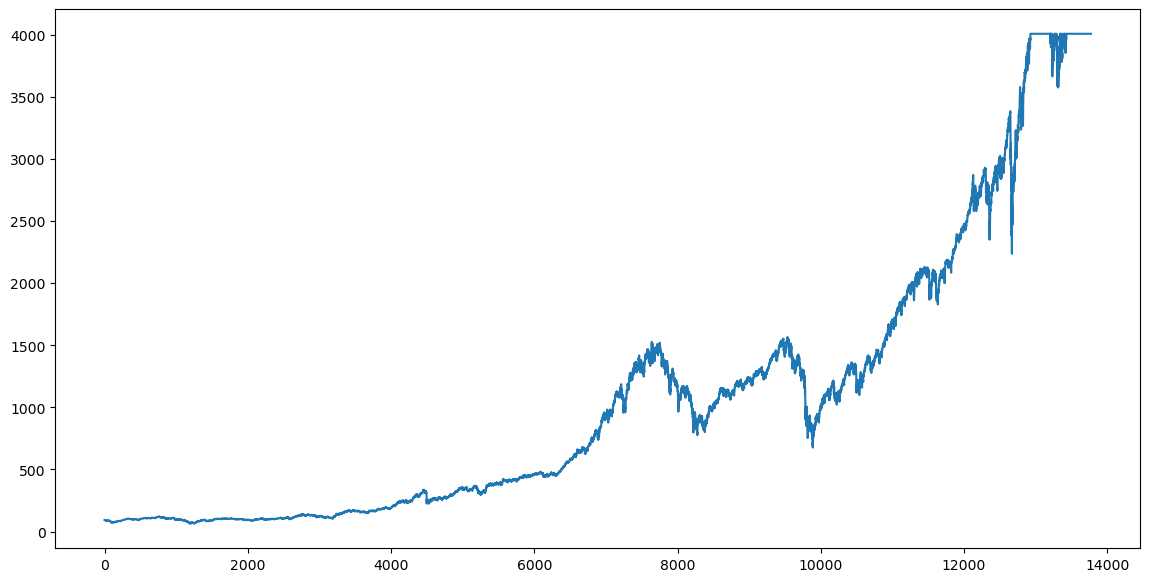

In [280]:
# X = synthetic(10000, 8, .01)
X = SPX[['Close']].values
assert(np.isfinite(X).all() == True)
print(X.shape)
# X = returns(X)
# remove 0.01% outliers
outliers = np.quantile(np.abs(X), 0.95)
X = np.clip(X, -outliers, outliers)
plot(X)

In [281]:
# compute log returns with a given forecast horizon
y = pd.Series(np.log(X[:, 0])).diff(forecast_horizon).shift(-forecast_horizon).values
y = np.where(y > 0, 1., 0)

# Make data stationary using log returns
X[:, 0] = pd.Series(np.log(X[:, 0])).diff().values

# outliers = np.quantile(np.abs(X), 0.5)
# X = np.clip(X, -outliers, outliers)

X = X[1:-forecast_horizon]
y = y[1:-forecast_horizon]

# remove outliers
# outliers = np.quantile(np.abs(X), 0.999)
# X = np.clip(X, -outliers, outliers)

# scale
# X = X / np.max(np.abs(X))

x_train, x_test, y_train, y_test = split(X, y)

print('y_train baseline: ', len(np.where(y_train > 0)[0]) / len(y_train))
print('y_test baseline: ', len(np.where(y_test > 0)[0]) / len(y_test))

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

assert(np.isfinite(X).all() == True)
assert(np.isfinite(y).all() == True)

y_train baseline:  0.548736853518378
y_test baseline:  0.5067136253576932
(9223, 1) (4543, 1)
(9223,) (4543,)


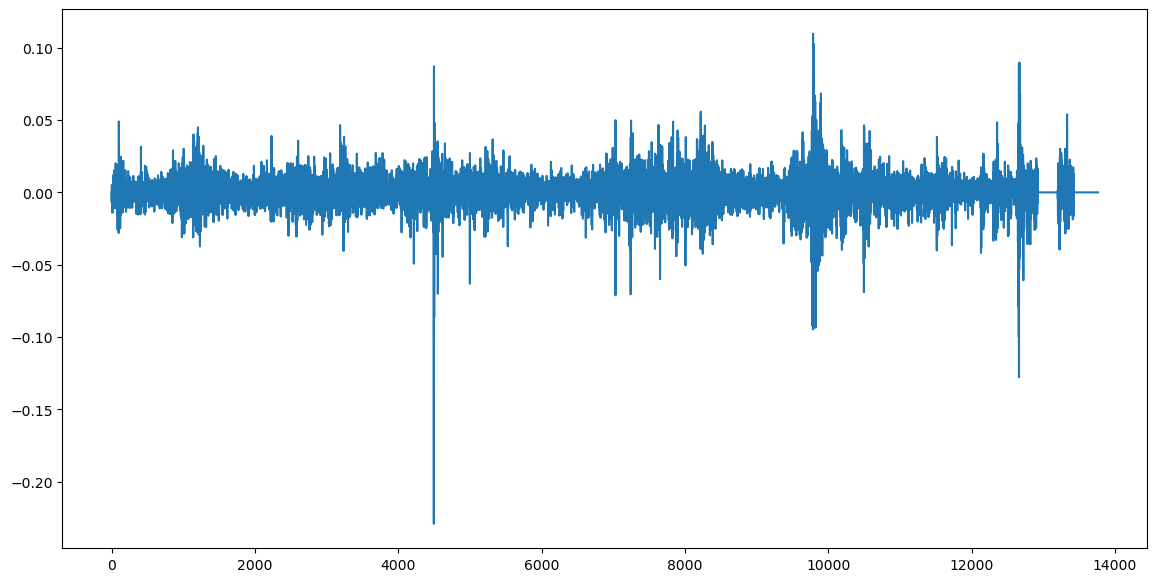

In [282]:
plot(X)

# Data Generation

In [283]:
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, timesteps=timesteps):
        self.timesteps = timesteps
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data = data
        self.indexes = np.arange(len(self.data) - timesteps - timesteps)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size
    
    def get_window(self, idx):
        x = self.data[idx:idx+self.timesteps]
        return scale(x) * 2. - 1.

    def __getitem__(self, batch):
        'Generate one batch of data'
        x = []
        y = []
        labels = []
        
        indexes = self.indexes[batch*self.batch_size//2:(batch+1)*self.batch_size//2]

        for idx in indexes:
            x_positive = self.get_window(idx)
            y_positive = self.get_window(idx + self.timesteps)
            
            y_negative = y_positive * -1.

            # v = np.random.choice(np.arange(3))

            # if v == 1:
            #     y_negative = self.get_window(np.random.choice(indexes))
            # elif v == 2:
            #     # make y_negative normal distribution from same range as y_positive
            #     y_negative = np.random.lognormal(np.mean(x_positive), np.std(x_positive), x_positive.shape[0]) - 1.
            #     y_negative = np.clip(y_negative, -1.0, 1.0)
            #     y_negative = np.expand_dims(y_negative, -1)

            # positive sample
            x.append(x_positive)
            y.append(y_positive)
            labels.append(1)

            # negative sample
            x.append(x_positive)
            y.append(y_negative)
            labels.append(0)
        
        labels = np.expand_dims(np.array(labels), axis=-1)
        return (np.array(x), np.array(y)), labels

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [284]:
dg = DataGenerator(x_train, batch_size=16, shuffle=False)

print(len(dg))

# get the first batch
(bx, by), labels = dg.__getitem__(0)
print(f"x shape: {bx.shape}, y shape: {by.shape}, labels shape: {labels.shape}")

561
x shape: (16, 120, 1), y shape: (16, 120, 1), labels shape: (16, 1)


# Inspecting Windows

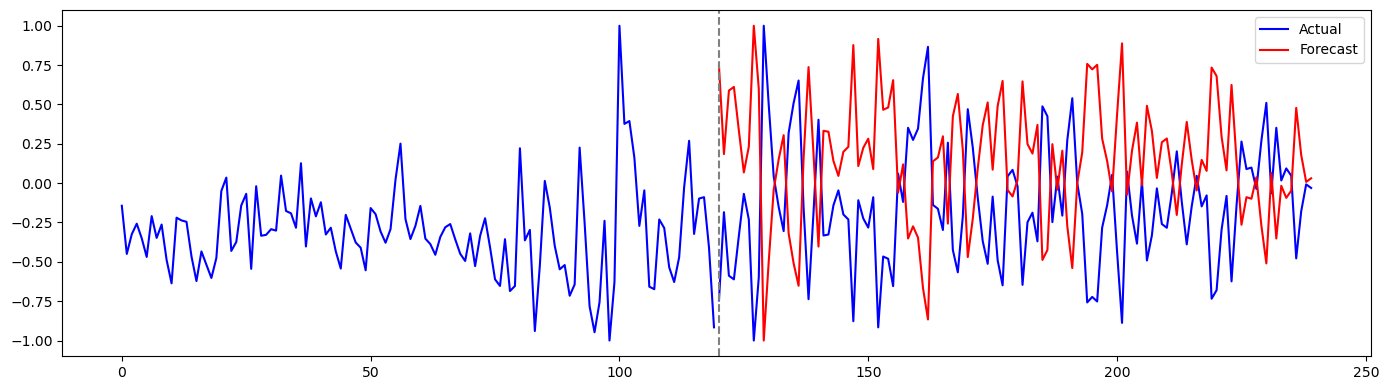

In [285]:
def plot_forecast(x, y, y_pred):
    t1 = np.arange(0, len(x), 1)
    t2 = np.arange(len(x), len(x) + len(y), 1)
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(t1, x, color='blue')
    ax.plot(t2, y, color='blue', label='Actual')
    ax.plot(t2, y_pred, color='red', label='Forecast')
    ax.axvline(x=len(x), color='gray', linestyle='--')
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_forecast(bx[0, :, 0], by[0, :, 0], by[1, :, 0])
# plot_forecast(x[2, :, 0], y[2, :, 0], y[3, :, 0])

# Model Architecture

In [286]:
def build_encoder(input_shape, code_size):
    input = Input(shape=input_shape)
    x = Conv1D(32, 3, activation='relu', padding='same')(input)
    # x = Dropout(0.2)(x)
    # x = BatchNormalization()(x)
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    # x = Dropout(0.2)(x)
    # x = BatchNormalization()(x)
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    # x = LSTM(code_size)(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    return Model(input, x, name='encoder')

encoder = build_encoder((timesteps, features), code_size)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_112 (InputLayer)      [(None, 120, 1)]          0         
                                                                 
 conv1d_67 (Conv1D)          (None, 120, 32)           128       
                                                                 
 conv1d_68 (Conv1D)          (None, 120, 32)           3104      
                                                                 
 conv1d_69 (Conv1D)          (None, 120, 32)           3104      
                                                                 
 encoder_embedding (Dense)   (None, 120, 32)           1056      
                                                                 
Total params: 7,392
Trainable params: 7,392
Non-trainable params: 0
_________________________________________________________________


In [287]:
def build_context(input_shape, code_size):
    '''Build the autoregressive model doing predictions'''
    input = Input(shape=input_shape)
    x = LSTM(32, return_sequences=True, name="context")(input)
    # x = Dropout(.2)(x)
    # x = BatchNormalization()(x)
    x = LSTM(32, return_sequences=True)(x)
    x = LSTM(32, return_sequences=True)(x)
    x = Dense(code_size, activation="linear", name="preds")(x)
    return Model(input, x, name="context")

context = build_context((timesteps, code_size), code_size)
context.summary()

Model: "context"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_113 (InputLayer)      [(None, 120, 32)]         0         
                                                                 
 context (LSTM)              (None, 120, 32)           8320      
                                                                 
 lstm_22 (LSTM)              (None, 120, 32)           8320      
                                                                 
 lstm_23 (LSTM)              (None, 120, 32)           8320      
                                                                 
 preds (Dense)               (None, 120, 32)           1056      
                                                                 
Total params: 26,016
Trainable params: 26,016
Non-trainable params: 0
_________________________________________________________________


In [291]:
x_input = Input(input_shape)
encoded = encoder(x_input)

y_pred = context(encoded)
# y_pred = Dense(code_size, activation='linear')(encoded)

y_input = Input(input_shape)
y_encoded = encoder(y_input)

y_encoded = y_encoded[:, :forecast_horizon, :]
y_pred = y_pred[:, :forecast_horizon, :]

output = K.sum(y_encoded * y_pred, axis=-1)
output = K.mean(output, axis=-1, keepdims=True)  # along the temporal dimension
output = K.sigmoid(output)

model = Model(inputs=[x_input, y_input], outputs=output, name='CPC')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "CPC"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_117 (InputLayer)         [(None, 120, 1)]     0           []                               
                                                                                                  
 input_116 (InputLayer)         [(None, 120, 1)]     0           []                               
                                                                                                  
 encoder (Functional)           (None, 120, 32)      7392        ['input_116[0][0]',              
                                                                  'input_117[0][0]']              
                                                                                                  
 context (Functional)           (None, 120, 32)      26016       ['encoder[2][0]']              

In [292]:
batch_size = 256
epochs = 50

train_gen = DataGenerator(x_train, batch_size=batch_size, shuffle=True)
test_gen = DataGenerator(x_test, batch_size=batch_size, shuffle=True)

In [290]:
history = model.fit(train_gen, batch_size=batch_size, epochs=epochs, validation_data=test_gen)

Epoch 1/50
34/35 [============================>.] - ETA: 0s - loss: 0.6920 - binary_accuracy: 0.5414

/var/folders/k0/x79hb9j52592z6fm_kpxykrr0000gn/T/ipykernel_65089/1819135631.py:19: RuntimeWarning: invalid value encountered in divide
  return (data - np.min(data)) / (np.max(data) - np.min(data))


35/35 [==============================] - 8s 113ms/step - loss: 0.6922 - binary_accuracy: 0.5393 - val_loss: 0.6637 - val_binary_accuracy: 0.6514
Epoch 2/50
35/35 [==============================] - 2s 56ms/step - loss: 0.6826 - binary_accuracy: 0.5520 - val_loss: 0.6653 - val_binary_accuracy: 0.6082
Epoch 3/50
35/35 [==============================] - 2s 56ms/step - loss: 0.6811 - binary_accuracy: 0.5567 - val_loss: 0.6514 - val_binary_accuracy: 0.6360
Epoch 4/50
35/35 [==============================] - 2s 56ms/step - loss: 0.6740 - binary_accuracy: 0.5684 - val_loss: 0.6472 - val_binary_accuracy: 0.6252
Epoch 5/50
35/35 [==============================] - 2s 56ms/step - loss: 0.6704 - binary_accuracy: 0.5783 - val_loss: 0.6186 - val_binary_accuracy: 0.6521
Epoch 6/50
35/35 [==============================] - 2s 56ms/step - loss: 0.6720 - binary_accuracy: 0.5763 - val_loss: 0.6174 - val_binary_accuracy: 0.6616
Epoch 7/50
35/35 [==============================] - 3s 81ms/step - loss: 0.6674 

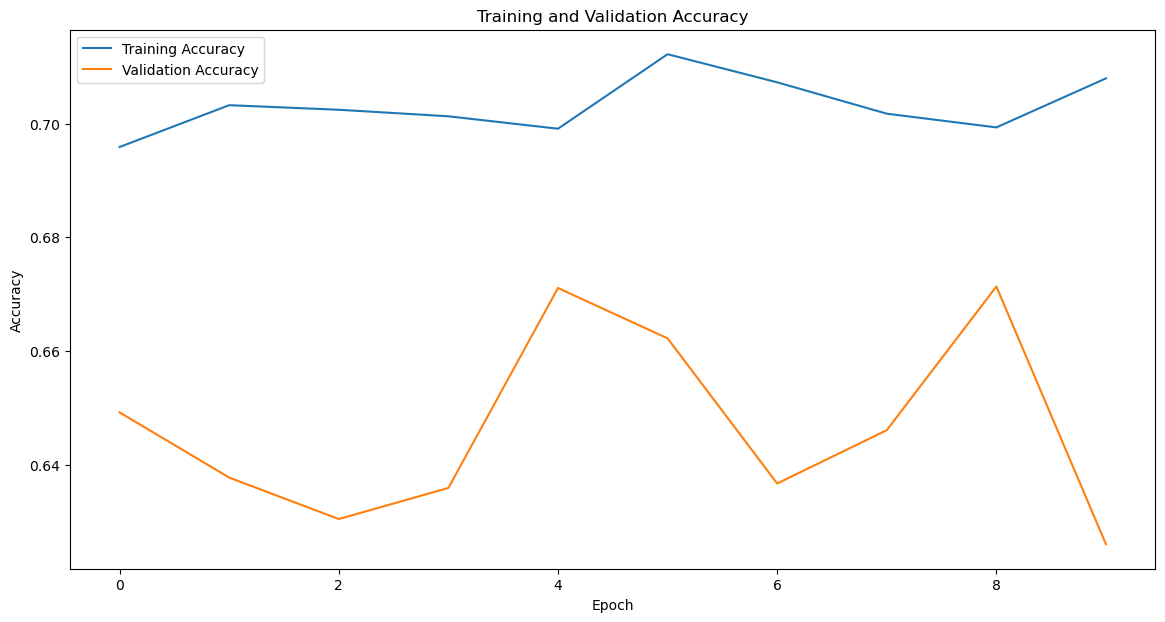

In [50]:
plot_training(history)

In [51]:
encoder.save('encoder11_08.h5', include_optimizer=False)

In [60]:
encoder = load_model('encoder11_08.h5', compile=True)

def compute_embeddings(x, y):
    x = window(x, timesteps, 1)
    for i in range(len(x)):
        x[i] = scale(x[i]) * 2. - 1.
    return encoder.predict(x)[:, -1, :], y[timesteps:]
    # return encoder.predict(x), y[timesteps:]

# x_train_embeds = encoder.predict(x_train)[:, -1, :]
# x_test_embeds = encoder.predict(x_test)[:, -1, :]

x_train_embeds, y_train_embeds = compute_embeddings(x_train, y_train)
x_test_embeds, y_test_embeds = compute_embeddings(x_test, y_test)

print(x_train_embeds.shape, x_test_embeds.shape)
print(y_train_embeds.shape, y_test_embeds.shape)

135/135 [==============================] - 1s 4ms/step
(8967, 32) (4290, 32)
(8967,) (4290,)


In [61]:
def build_forecasting(input_shape):
    input = Input(input_shape)
    x = Dense(128, activation='relu')(input)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    # x = BatchNormalization()(x)
    # x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(input, x)

fm = build_forecasting(x_train_embeds.shape[1:])
fm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
fm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_3 (Dense)             (None, 128)               4224      
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 


 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,057
Trainable params: 12,801
Non-trainable params: 256
_________________________________________________________________


In [62]:
history = fm.fit(x_train_embeds, y_train_embeds, epochs=40, batch_size=128, validation_data=(x_test_embeds, y_test_embeds))

Epoch 1/40
71/71 [==============================] - 2s 17ms/step - loss: 0.7341 - binary_accuracy: 0.5415 - val_loss: 0.6859 - val_binary_accuracy: 0.6277
Epoch 2/40
71/71 [==============================] - 1s 9ms/step - loss: 0.7072 - binary_accuracy: 0.5471 - val_loss: 0.6746 - val_binary_accuracy: 0.6159
Epoch 3/40
71/71 [==============================] - 1s 8ms/step - loss: 0.7026 - binary_accuracy: 0.5589 - val_loss: 0.6921 - val_binary_accuracy: 0.5310
Epoch 4/40
71/71 [==============================] - 1s 8ms/step - loss: 0.6965 - binary_accuracy: 0.5545 - val_loss: 0.6713 - val_binary_accuracy: 0.6240
Epoch 5/40
71/71 [==============================] - 1s 8ms/step - loss: 0.6928 - binary_accuracy: 0.5657 - val_loss: 0.6748 - val_binary_accuracy: 0.6138
Epoch 6/40
71/71 [==============================] - 1s 8ms/step - loss: 0.6907 - binary_accuracy: 0.5657 - val_loss: 0.6691 - val_binary_accuracy: 0.6112
Epoch 7/40
71/71 [==============================] - 1s 8ms/step - loss: 0.6

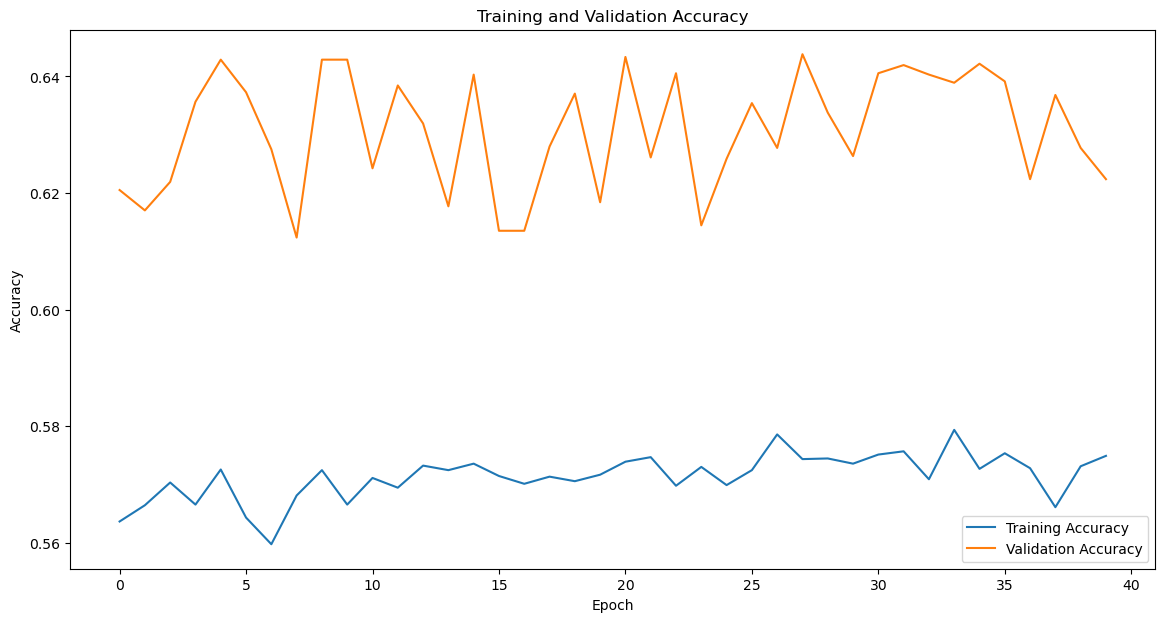

In [56]:
plot_training(history)

In [57]:
from sklearn.metrics import classification_report

y_pred = fm.predict(x_test_embeds)[:, 0]
y_pred = np.where(y_pred > 0.5, 1, 0)

print(classification_report(y_test_embeds, y_pred))

135/135 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

         0.0       0.42      0.15      0.22      1531
         1.0       0.65      0.89      0.75      2759

    accuracy                           0.62      4290
   macro avg       0.53      0.52      0.48      4290
weighted avg       0.57      0.62      0.56      4290



In [286]:
# naive test to show that forecasting doesn't work at all
x_train, x_test, y_train, y_test = split(scale(X), y)

def build_forecasting(input_shape):
    input = Input(input_shape)
    x = Dense(128, activation='relu')(input)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(input, x)

fm = build_forecasting(x_train.shape[1:])
fm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
fm.summary()

fm.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_72 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_72 (Dense)            (None, 128)               256       
                                                                 
 batch_normalization_6 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_73 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_7 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 64)                0  

In [287]:
from sklearn.metrics import classification_report

y_pred = fm.predict(x_test)[:, 0]
y_pred = np.where(y_pred > 0.5, 1, 0)

print(classification_report(y_test, y_pred))

142/142 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

         0.0       0.38      0.21      0.27      1686
         1.0       0.63      0.80      0.70      2856

    accuracy                           0.58      4542
   macro avg       0.50      0.50      0.49      4542
weighted avg       0.54      0.58      0.54      4542



In [327]:
log_returns_train = returns(x_train)
log_returns_train = log_returns_train[1:]
log_returns_train = log_returns_train[timesteps:]

features_train = x_train_embeds


((8967, 32), (9217, 1))